In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from datetime import datetime
import re
from itertools import chain

data_folder = 'data/'

# Explore movies metadata

In [86]:
movie_metadata = pd.read_csv(data_folder + "movie.metadata.tsv", sep='\t', header = None)
movie_metadata.columns = ['movie_ID','FB_ID','movie_name','release_date','box_office','length','languages','country','genres']
movie_metadata = movie_metadata.set_index('movie_ID')

#Drop freebase database ID, don't need it
movie_metadata = movie_metadata.drop(columns=['FB_ID'])

#Remove movies with non-defined release date
#Convert release date to datetime type, only keep year 
movie_metadata = movie_metadata[movie_metadata.release_date.notna()]
movie_metadata['release_date'] = movie_metadata.release_date.apply(lambda d:datetime.strptime(str(d[0:4]), "%Y"))
movie_metadata['release_date'] = [date.year for date in movie_metadata.release_date]

#Change release date in 1010
movie_metadata = movie_metadata.replace(1010,2010)

#Clean languages, country, genres columns
movie_metadata['languages'] = [lang.split('"')[3::4] for lang in movie_metadata.languages]
movie_metadata['country'] = [lang.split('"')[3::4] for lang in movie_metadata.country]
movie_metadata['genres'] = [lang.split('"')[3::4] for lang in movie_metadata.genres]

movie_metadata.sample(10)

,movie_name,release_date,box_office,length,languages,country,genres
movie_ID,,,,,,,
8291511,Lost,1956,NaN,89.0,[English Language],[United Kingdom],"[Thriller, Mystery, Crime Fiction, Detective]"
28330207,"Slunce, seno a pár facek",1989,NaN,128.0,[Czech Language],[Czechoslovakia],[Comedy film]
31743981,Claude Duval,1924,NaN,NaN,[],[United Kingdom],"[Crime Fiction, Silent film, Drama, Adventure]"
18357367,Cold Light,2003,NaN,93.0,"[Icelandic Language, German Language, English ...","[Iceland, Germany, United Kingdom, Norway]",[Drama]
26693888,Shalabam,2008,NaN,NaN,[Malayalam Language],[India],"[Social problem film, Romance Film, Family Dra..."
33483307,The New Adventures of Gigantor,1980,NaN,1530.0,[Japanese Language],[Japan],"[Science Fiction, Anime, Action, Adventure, An..."
36107936,Jersey Shore Shark Attack,2012,NaN,NaN,[English Language],[United States of America],"[Science Fiction, Action]"
15202473,Julia Misbehaves,1948,NaN,99.0,[English Language],[United States of America],"[Romantic comedy, Comedy, Black-and-white]"
7593644,Soldiers Pay,2004,NaN,35.0,[English Language],[United States of America],"[Culture & Society, Short Film, War film, Poli..."


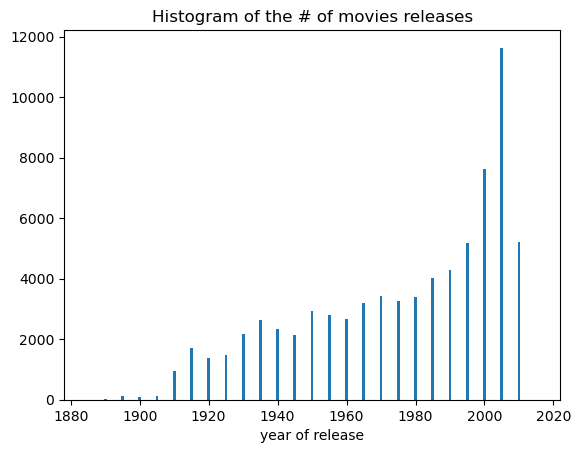

In [87]:
#Let's look at the distibution of the release date 
plt.bar(np.unique(movie_metadata.release_date//5*5),movie_metadata.groupby((movie_metadata.release_date//5)*5).movie_name.count())
plt.xlabel('year of release'); plt.title('Histogram of the # of movies releases')
plt.show()

The distrinution of release date is not uniform. They're few movies release before the 1950 in the dataset. 

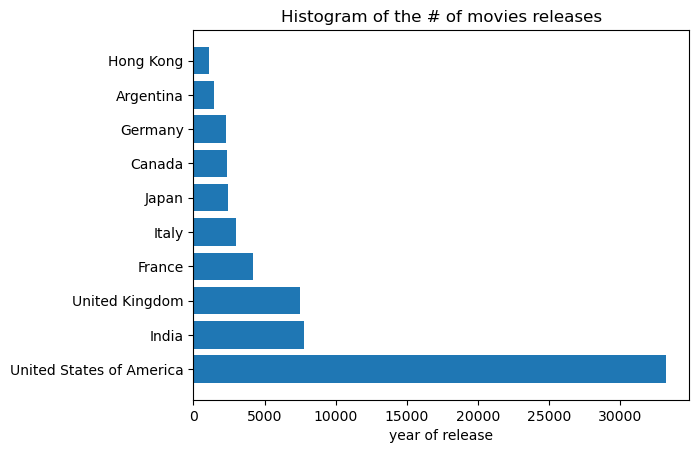

In [123]:
#Let's look at the country of origin of the movies
country, count_country =  np.unique((list(chain.from_iterable(movie_metadata.country))),return_counts=True)
count_country = pd.DataFrame(count_country, index = country, columns=['count'])
count_country = count_country.sort_values(by=['count'], ascending=False)

#Let's only look at the top 10 producing movie country
plt.barh(count_country.iloc[0:10].index, np.squeeze(count_country.iloc[0:10].values))
plt.xlabel('year of release',); plt.title('Histogram of the # of movies releases')
plt.show()

In [124]:
def get_count_country(x):
    country, count_country = np.unique((list(chain.from_iterable(x))),return_counts=True)
    count_country = pd.DataFrame({'country': country,'count': count_country})
    return count_country.sort_values(by=['count'], ascending=False) 

#Is the distribution is the same accross decades
country_count = movie_metadata.groupby((movie_metadata.release_date//5)*5).country.apply(get_count_country)
country_count.head()

country  count
release_date                                   
1885         0            United Kingdom      2
1890         2  United States of America     12
             0                    France      3
             1            United Kingdom      1
1895         4                    France     76

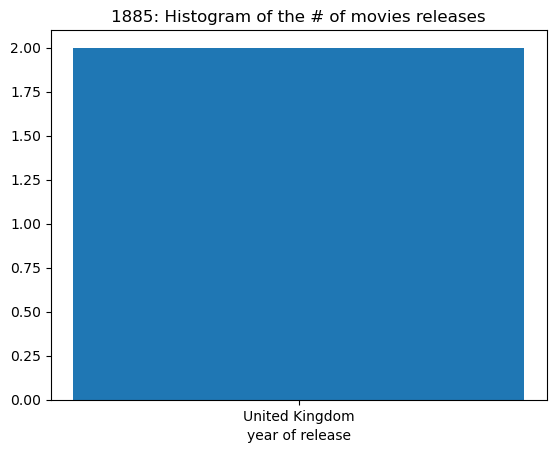

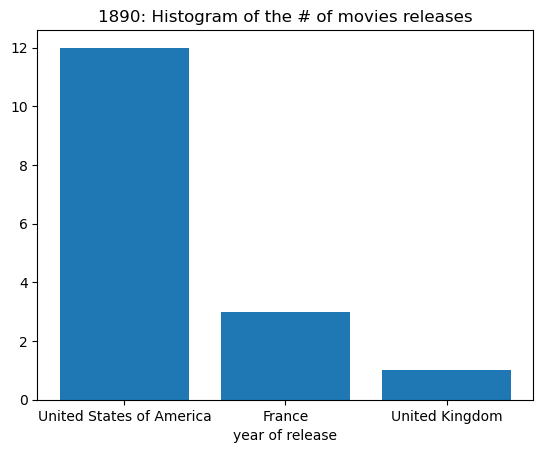

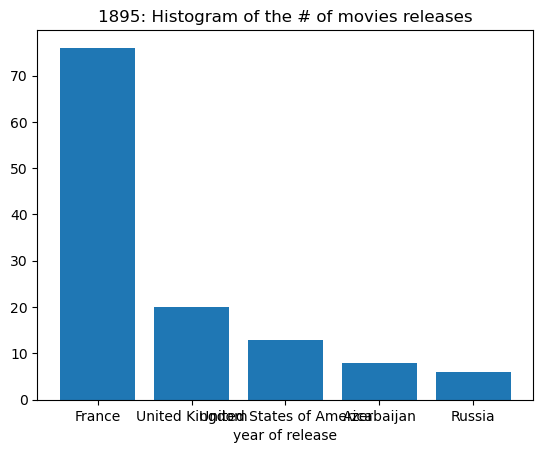

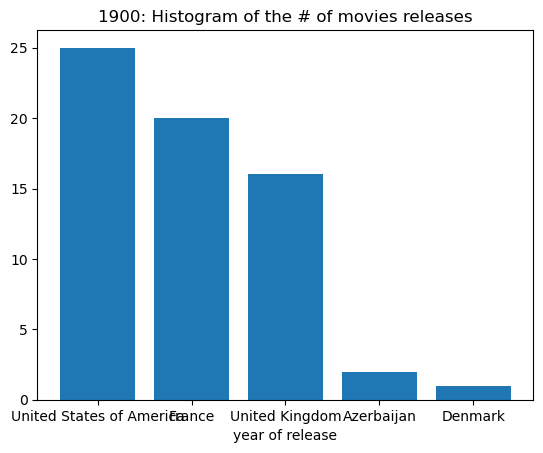

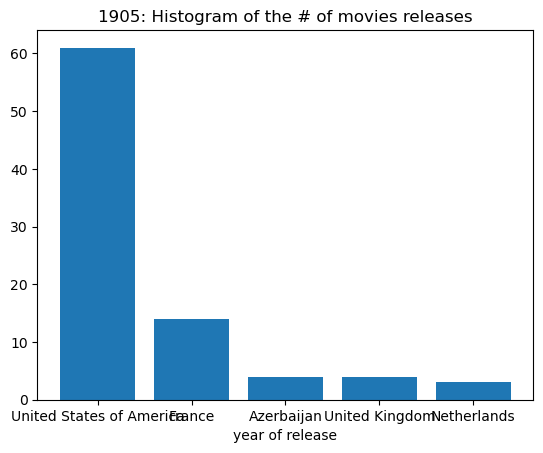

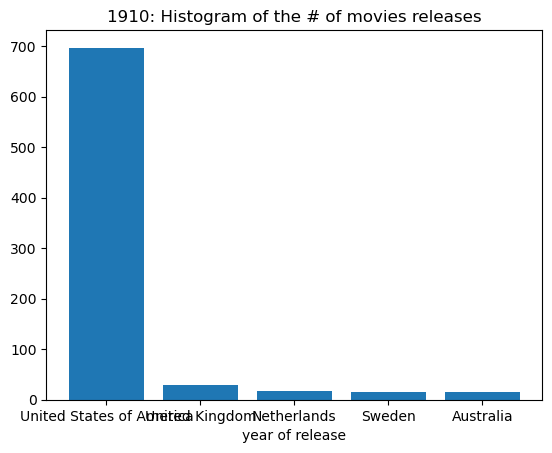

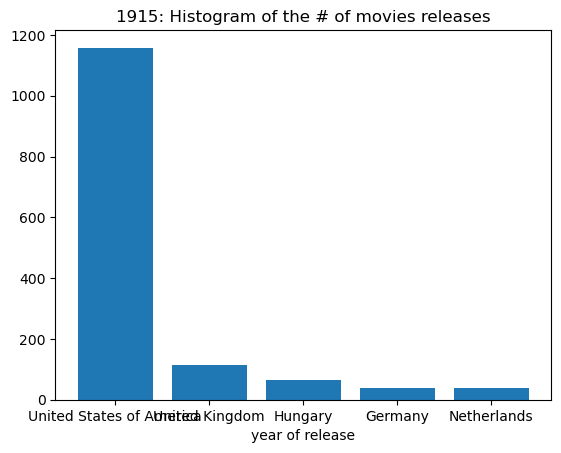

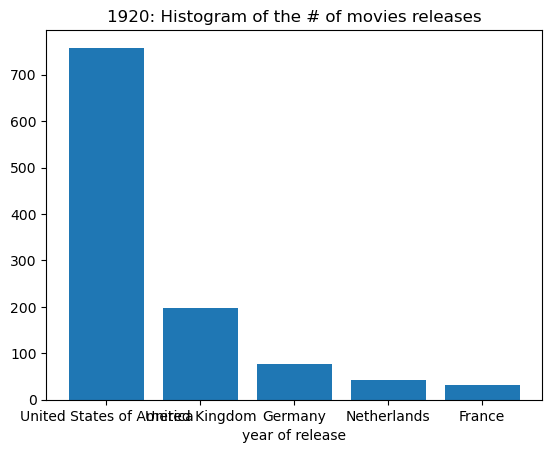

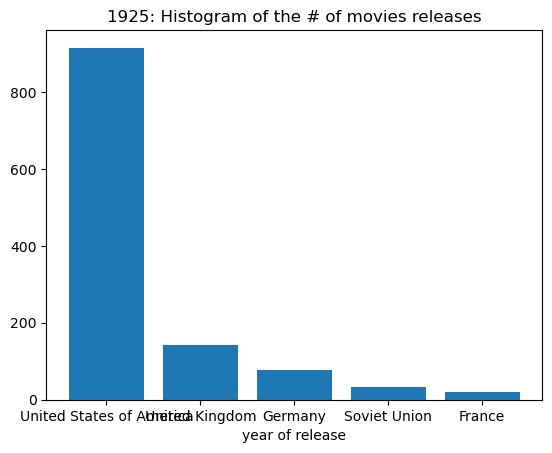

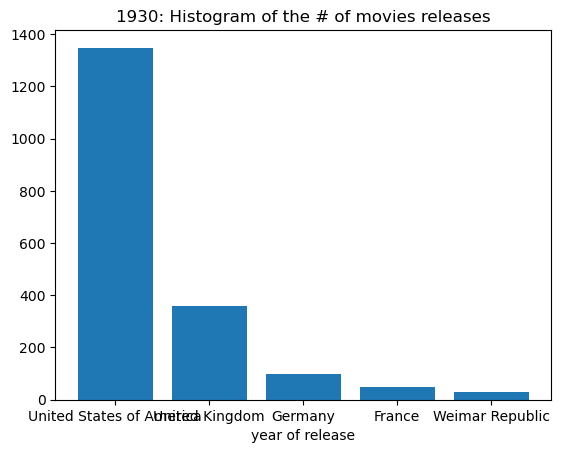

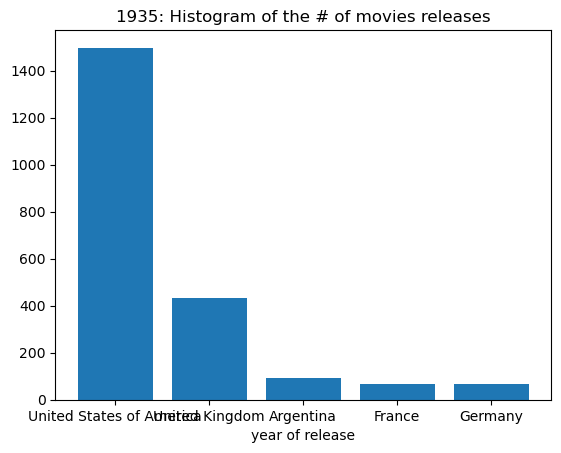

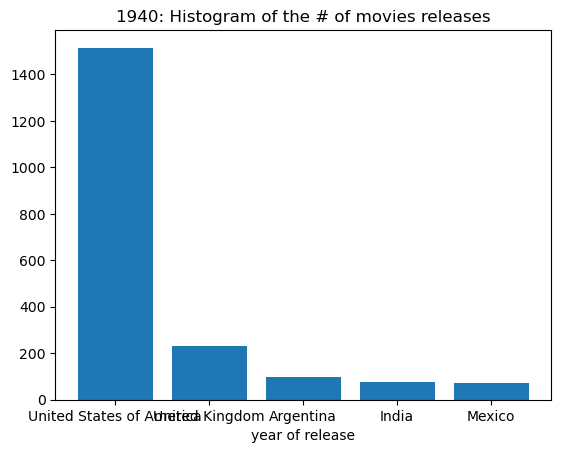

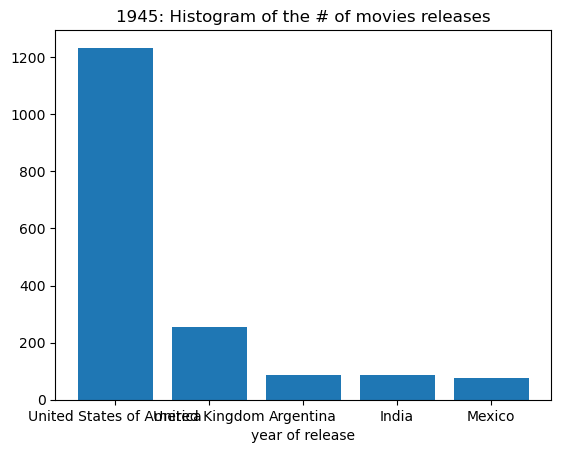

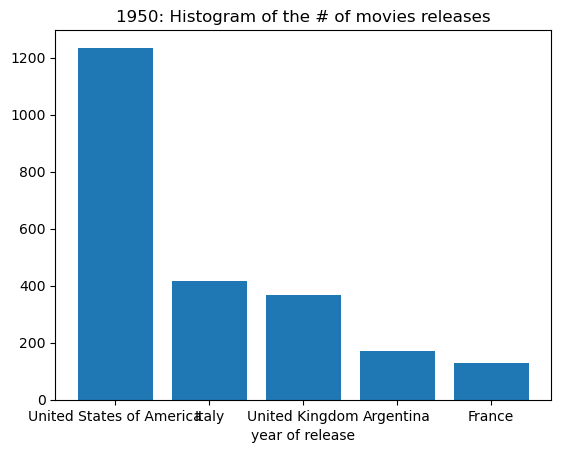

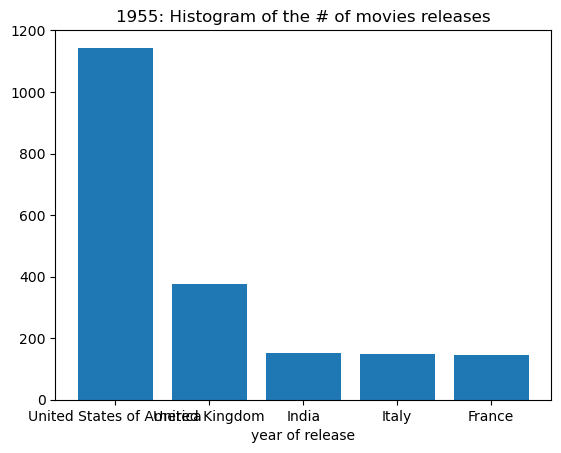

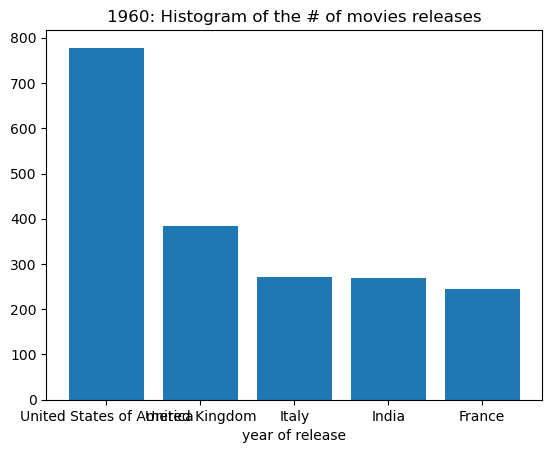

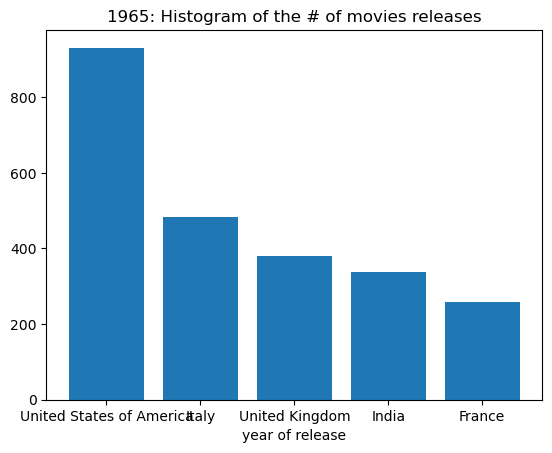

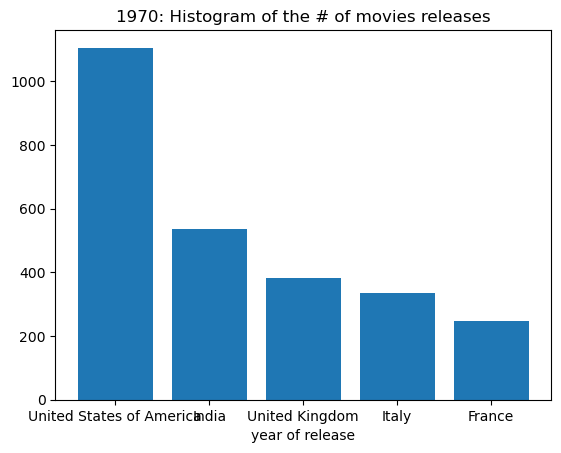

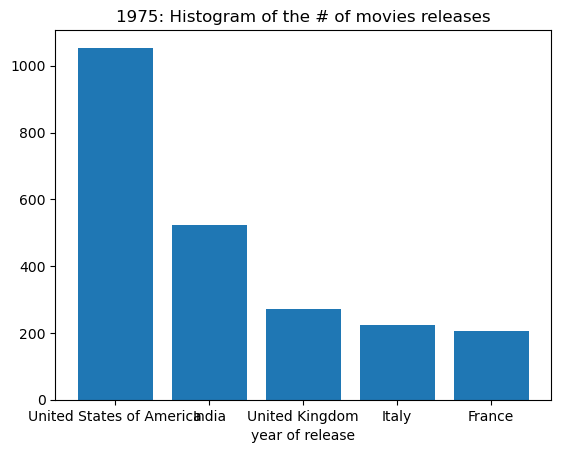

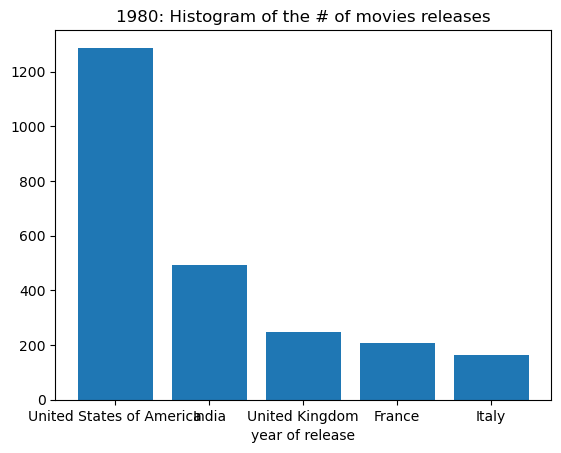

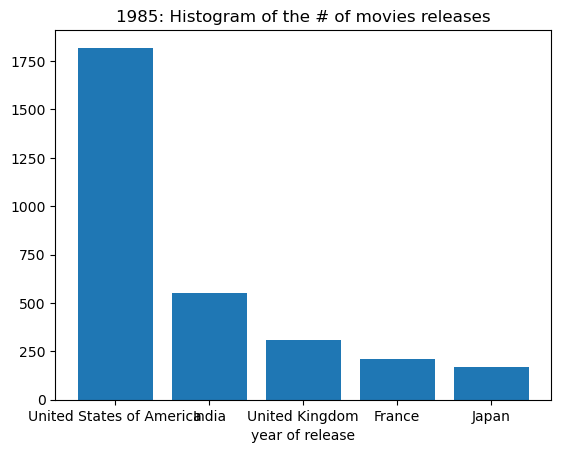

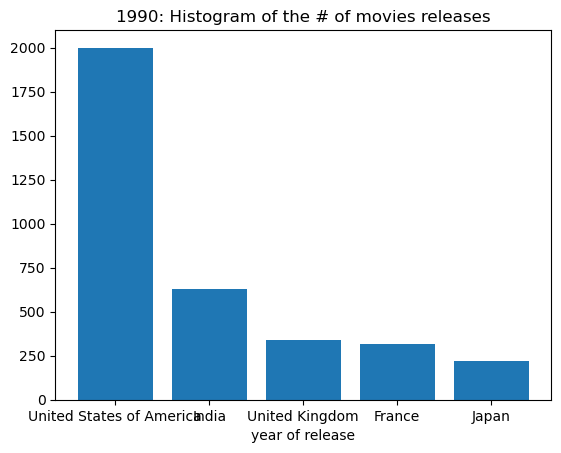

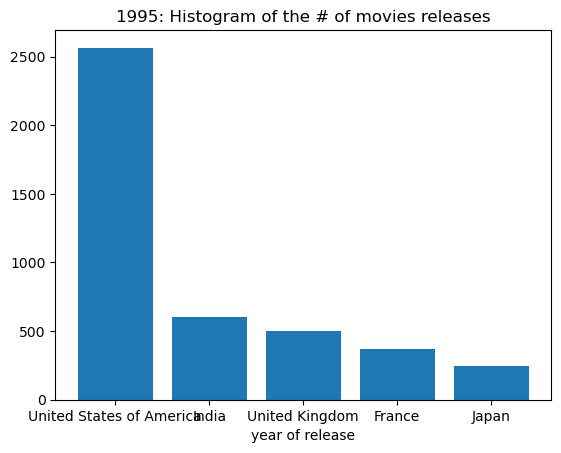

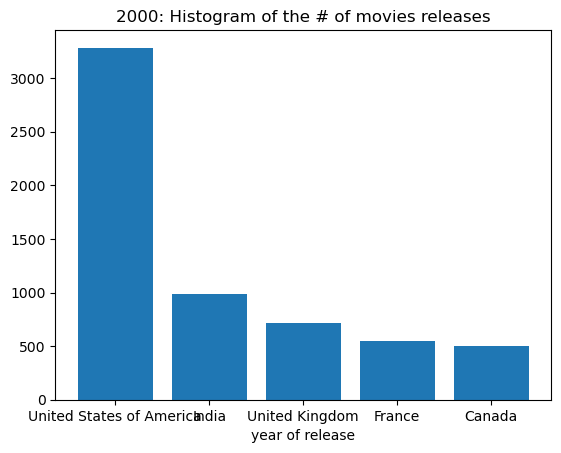

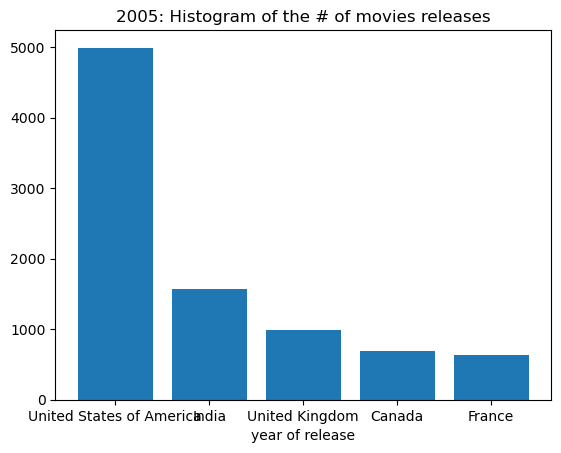

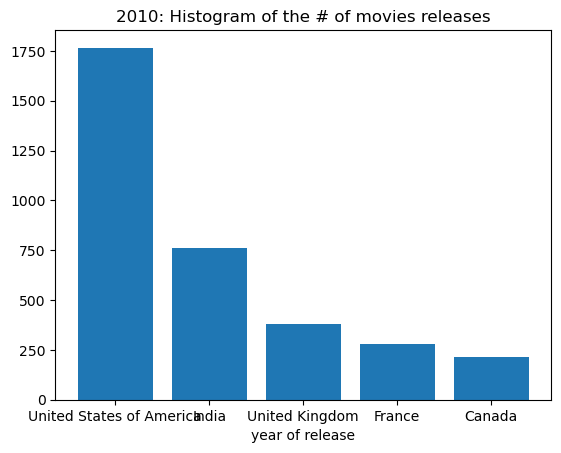

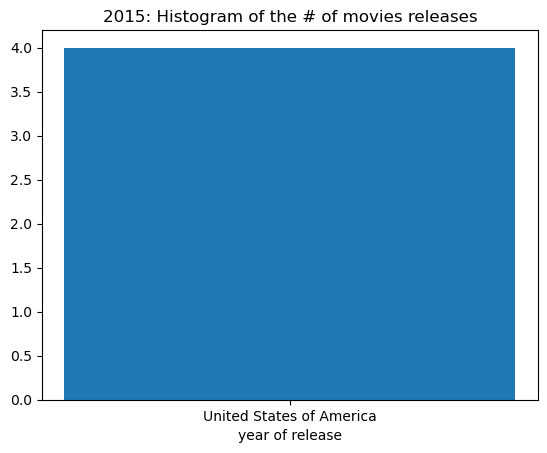

In [91]:
for decade in np.unique(movie_metadata.release_date//5*5):
    if (country_count.loc[decade].shape[0] >= 5):
        plt.bar(country_count.loc[decade]['country'].iloc[0:5], country_count.loc[decade]['count'].iloc[0:5])
    else:
        plt.bar(country_count.loc[decade]['country'].values, country_count.loc[decade]['count'])
    
    plt.xlabel('year of release'); plt.title(str(decade) + ': Histogram of the # of movies releases')
    plt.show()

We want to female character portrayal, it is heavealy influence by by the culture of the producing country. Thus, we will focus on the USA to have a homologeous culture since it is the top producing country since 1900. 

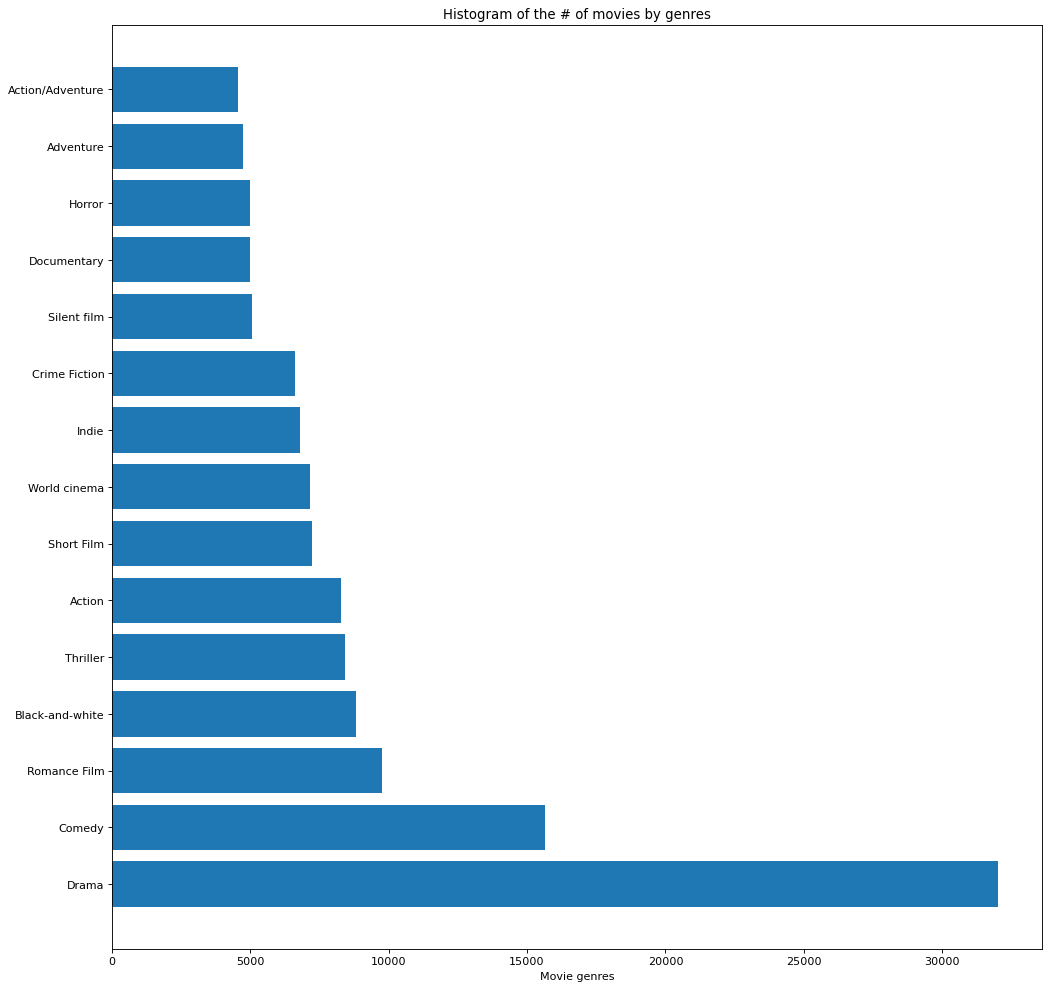

                genre  count
114             Drama  32015
75             Comedy  15648
288      Romance Film   9770
43    Black-and-white   8817
343          Thriller   8408
2              Action   8275
305        Short Film   7208
359      World cinema   7155
196             Indie   6779
98      Crime Fiction   6625
306       Silent film   5056
110       Documentary   4998
189            Horror   4982
8           Adventure   4732
5    Action/Adventure   4557
137       Family Film   4165
232           Musical   3984
78        Comedy film   3717
290    Romantic drama   3345
235           Mystery   3056


In [126]:
#Let's look at the genres of the movies
def get_count_genre(x):
    genre, count_genre = np.unique((list(chain.from_iterable(x))), return_counts=True)
    count_genre = pd.DataFrame({'genre': genre,'count': count_genre})
    return count_genre.sort_values(by=['count'], ascending=False) 

count_genre = get_count_genre(movie_metadata.genres)

#Let's only look at the top 15 genres
plt.figure(figsize=(15, 15), dpi=80)
plt.barh(count_genre.iloc[0:15].genre, count_genre.iloc[0:15]['count'])
plt.xlabel('Movie genres'); plt.title('Histogram of the # of movies by genres')
plt.show()

print(count_genre.iloc[0:20])

In [92]:
def check_USA_produced(countries):
    return any('United States of America' in country for country in countries)

#Select only movies produced in the US
mask_usa = [check_USA_produced(x) for x in movie_metadata.country]
usa_movie = movie_metadata[mask_usa]

usa_movie.head()

,movie_name,release_date,box_office,length,languages,country,genres
movie_ID,,,,,,,
975900,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
13696889,The Gangsters,1913,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi..."
10408933,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]"
175026,Sarah and Son,1930,NaN,86.0,[English Language],[United States of America],"[Drama, Black-and-white]"


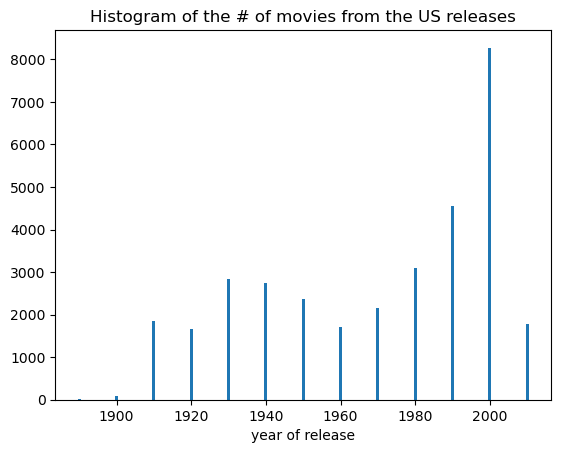

In [157]:
#Look again at distribution of movies by decades
plt.bar(np.unique(usa_movie.release_date//10*10),usa_movie.groupby((usa_movie.release_date//10)*10).movie_name.count())
plt.xlabel('year of release'); plt.title('Histogram of the # of movies from the US releases')
plt.show()

The distribution is simialr to the one Take from?? What is enough data to the evolution analysis

In [ ]:
#Only take movie released from 1960
usa_movie_1960 = movie_metadata[mask_usa]
usa_movie.head()

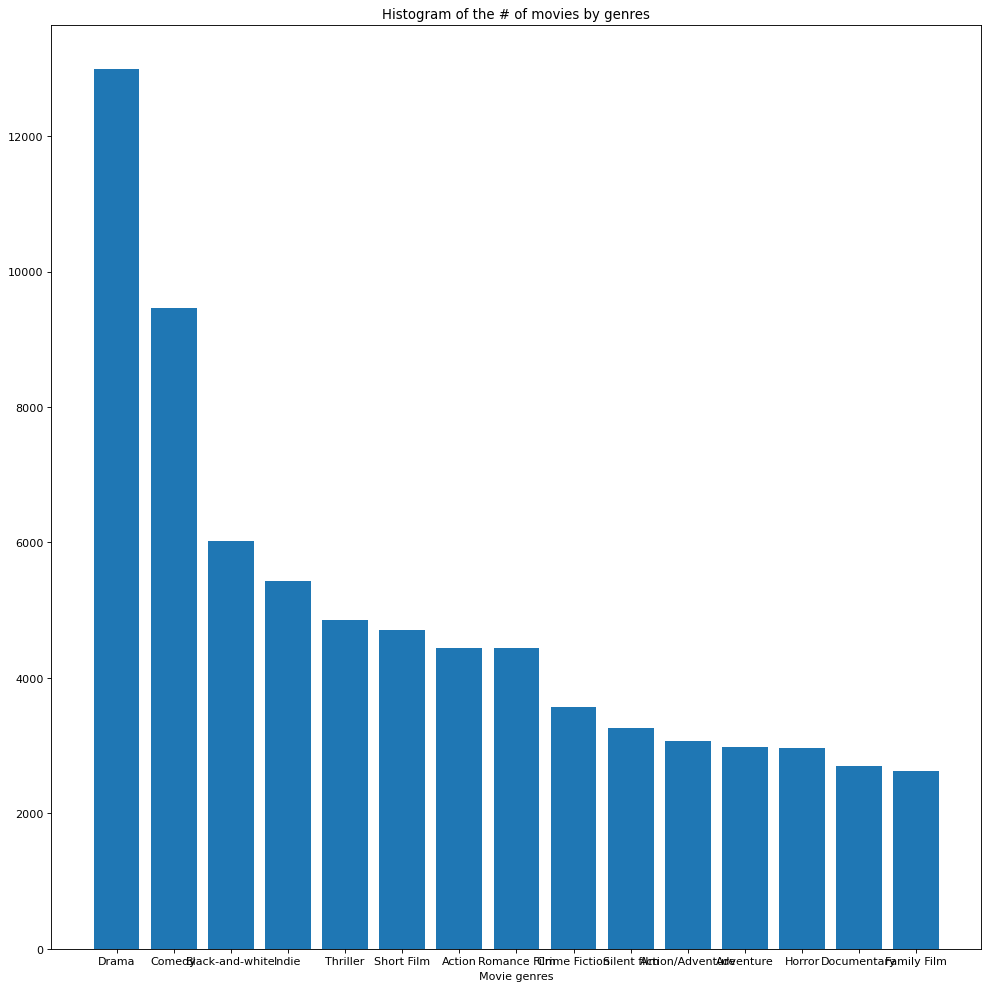

                genre  count
108             Drama  12994
70             Comedy   9469
42    Black-and-white   6023
187             Indie   5426
323          Thriller   4850
287        Short Film   4708
2              Action   4440
271      Romance Film   4439
93      Crime Fiction   3570
288       Silent film   3257
5    Action/Adventure   3073
8           Adventure   2979
180            Horror   2961
104       Documentary   2701
131       Family Film   2623
282   Science Fiction   1883
332           Western   1822
222           Mystery   1811
272   Romantic comedy   1791
219           Musical   1678


In [172]:
#Let's look at the genres of the movies
def get_count_genre(x):
    genre, count_genre = np.unique((list(chain.from_iterable(x))), return_counts=True)
    count_genre = pd.DataFrame({'genre': genre,'count': count_genre})
    return count_genre.sort_values(by=['count'], ascending=False) 

count_genre = get_count_genre(usa_movie.genres)

#Let's only look at the top 15 genres
plt.figure(figsize=(15, 15), dpi=80)
plt.bar(count_genre.iloc[0:15].genre, count_genre.iloc[0:15]['count'])
plt.xlabel('Movie genres'); plt.title('Histogram of the # of movies by genres')
plt.show()

print(count_genre.iloc[0:20])

In [344]:
#Is the distribution is the same accross decades
genre_count = usa_movie.groupby((usa_movie.release_date//10)*10).genres.apply(get_count_genre)
genre_count.sample(10)

genre  count
release_date                            
1950         93      Family Drama     22
1990         120  Filipino Movies      2
             107   Extreme Sports      2
1960         49   Christmas movie      4
1950         41   Childhood Drama      1
1990         235    Splatter film      1
1960         78         Docudrama     14
2000         95     Ensemble Film    116
             232           Satire     85
1980         188     Period piece    124

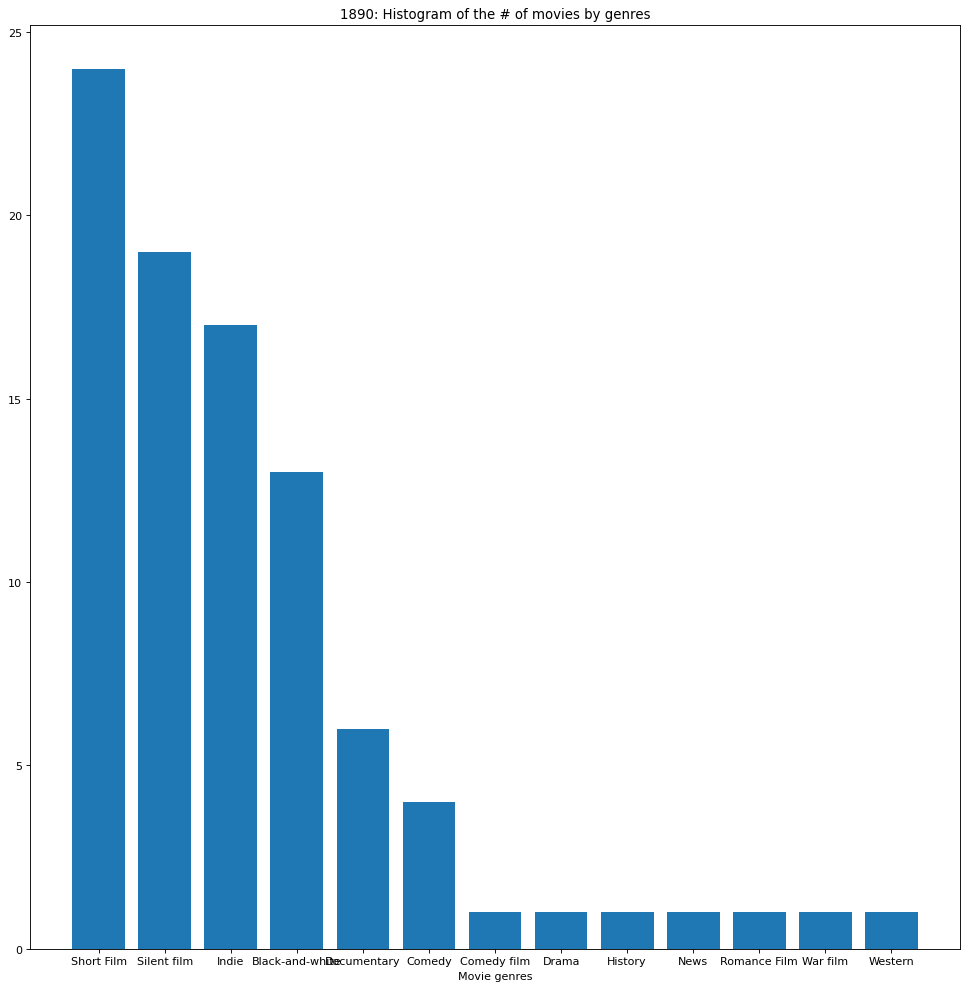

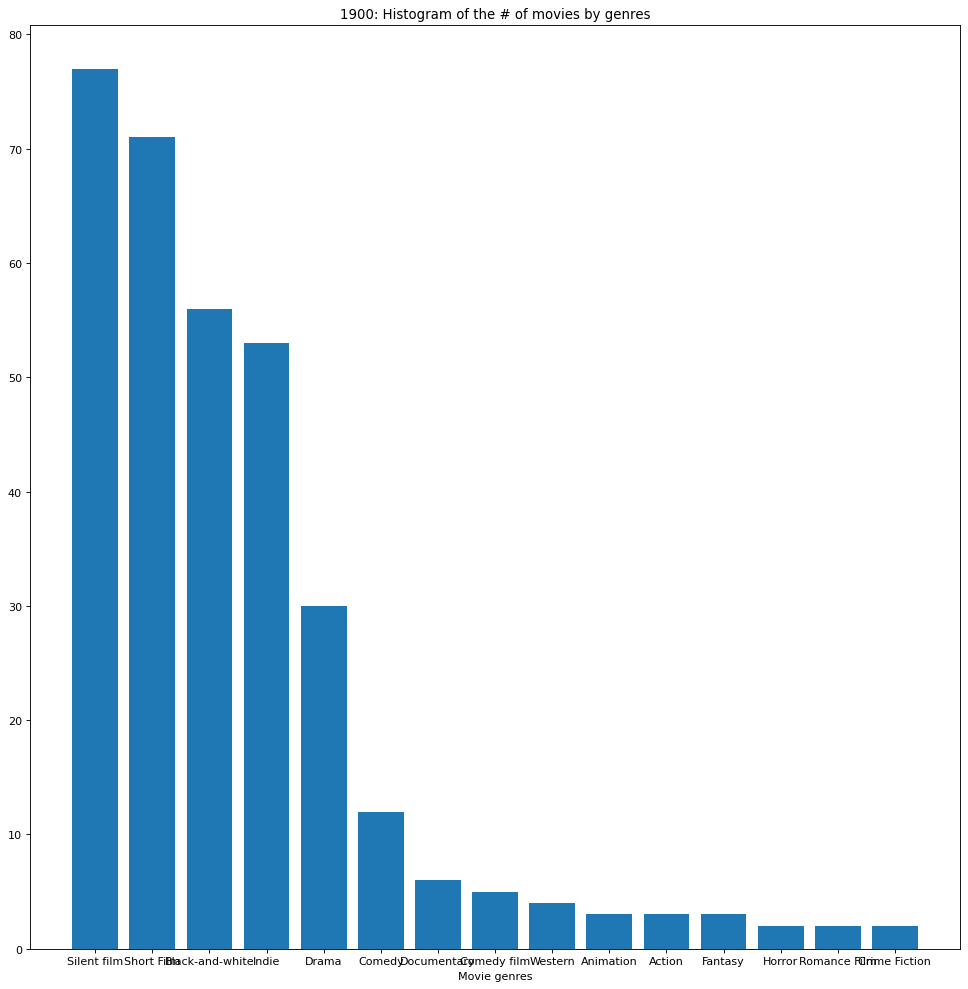

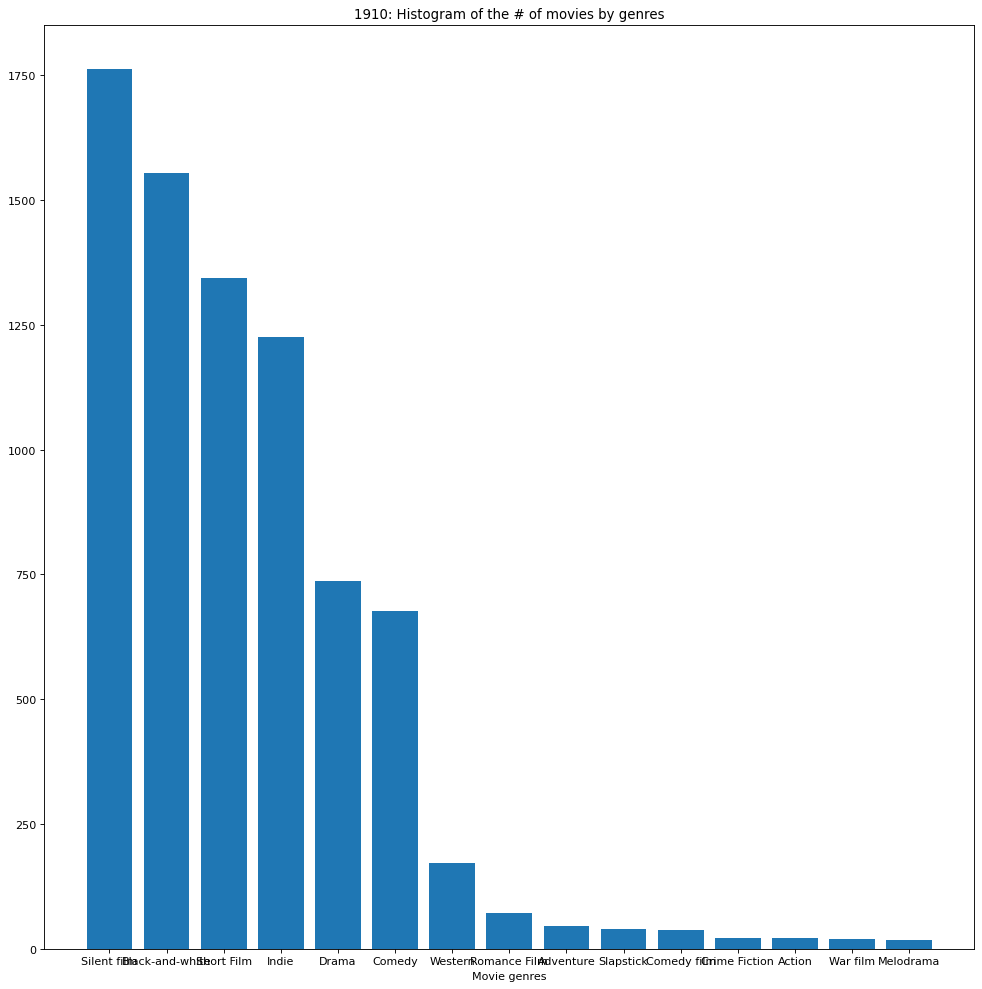

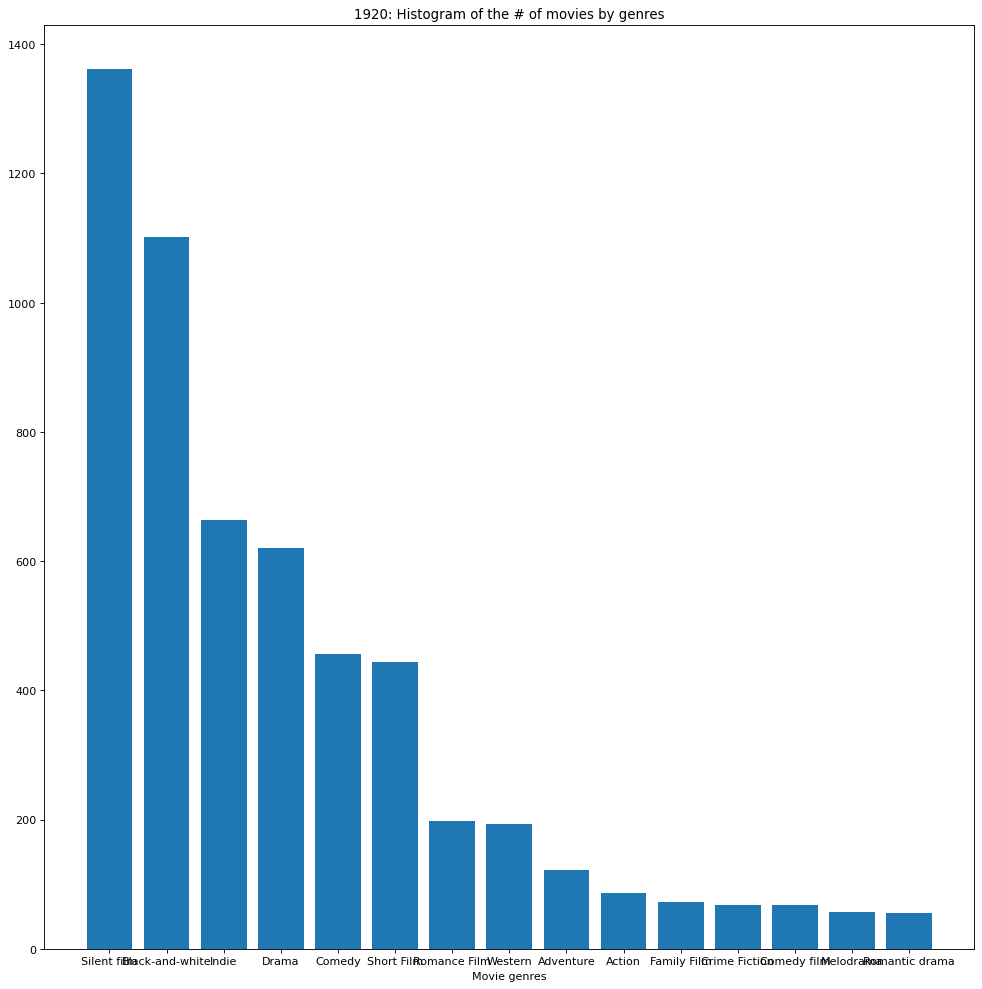

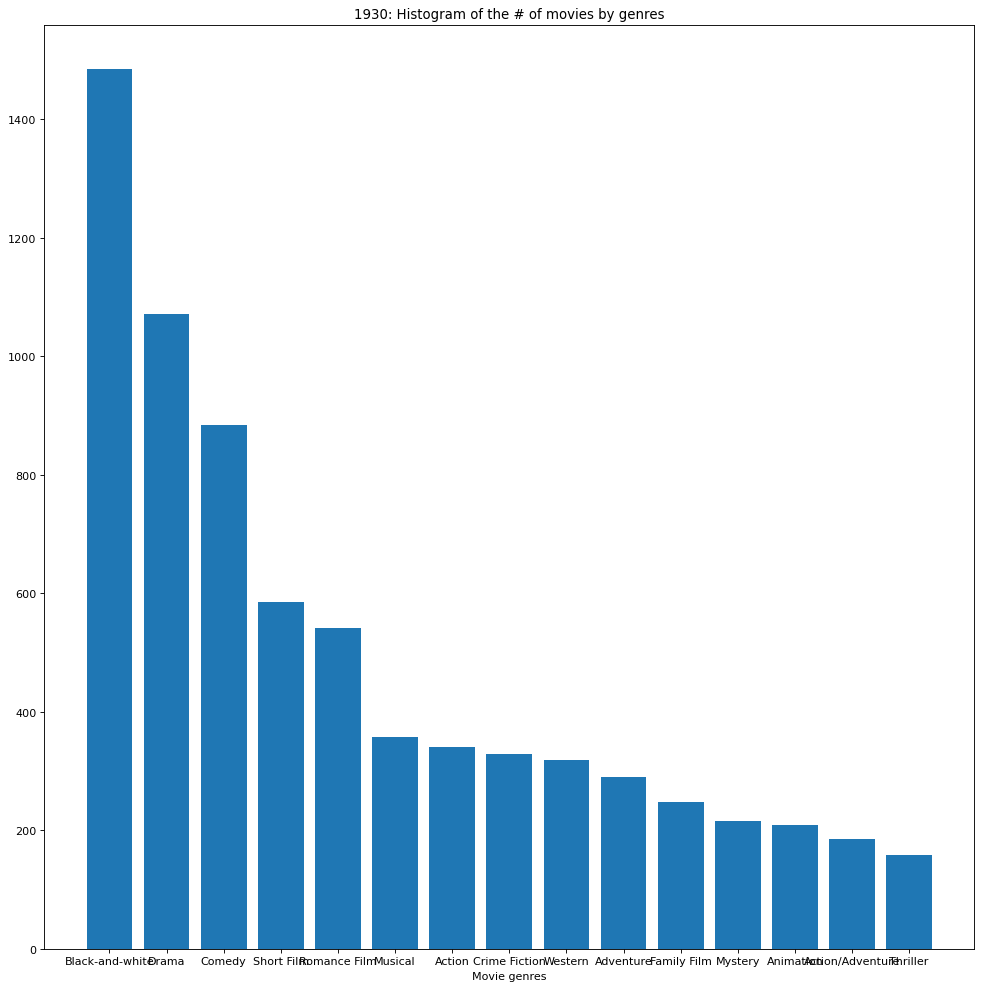

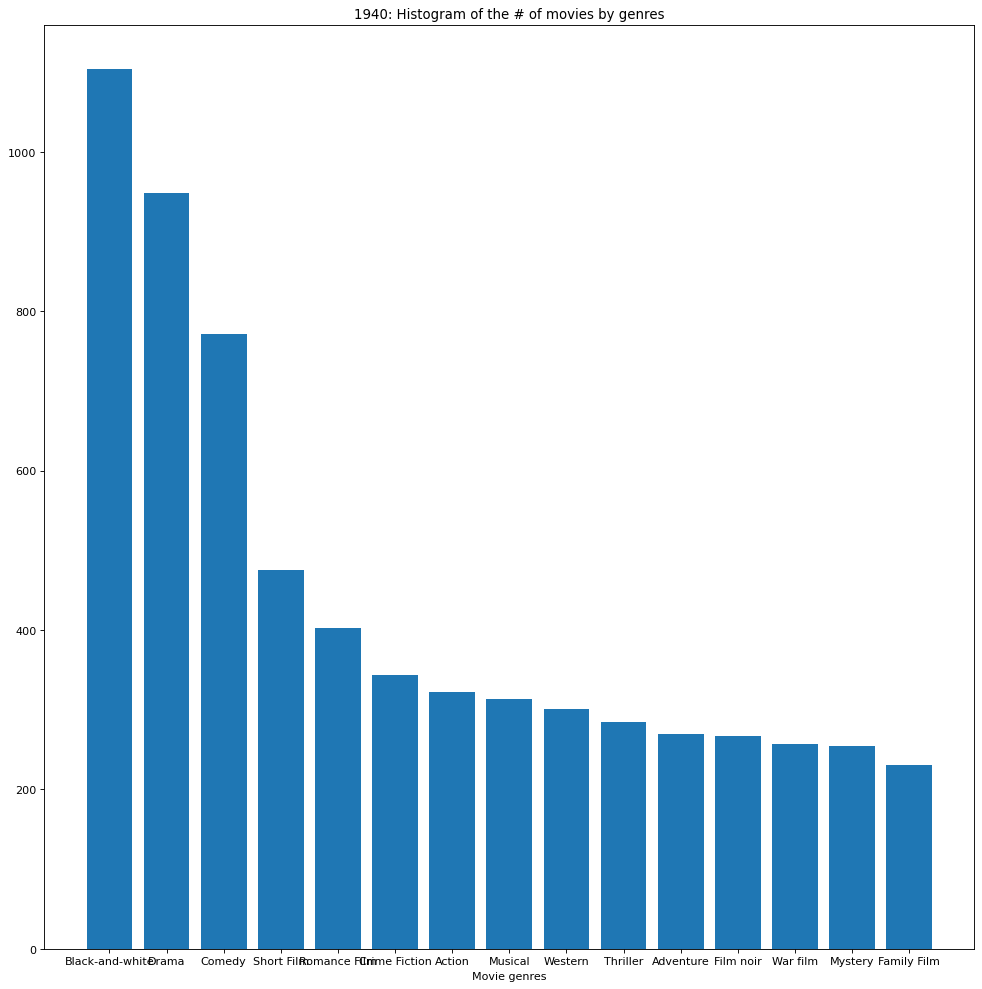

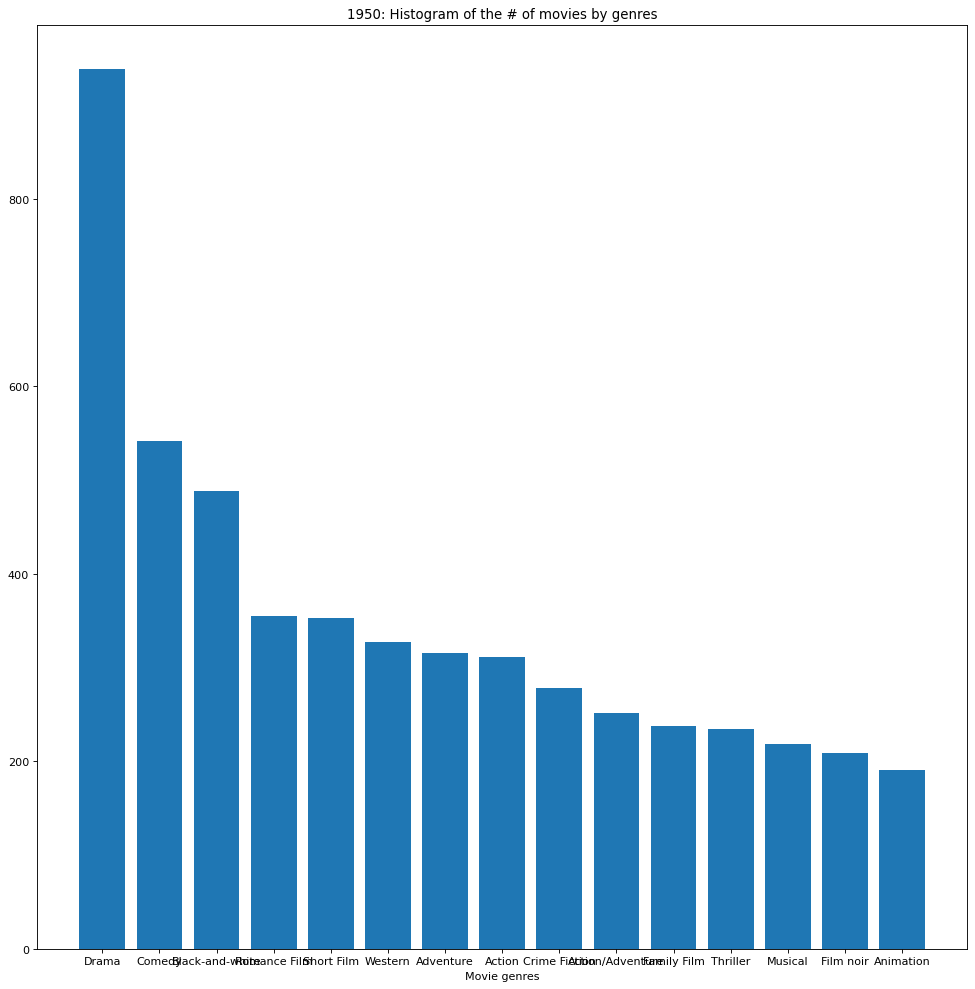

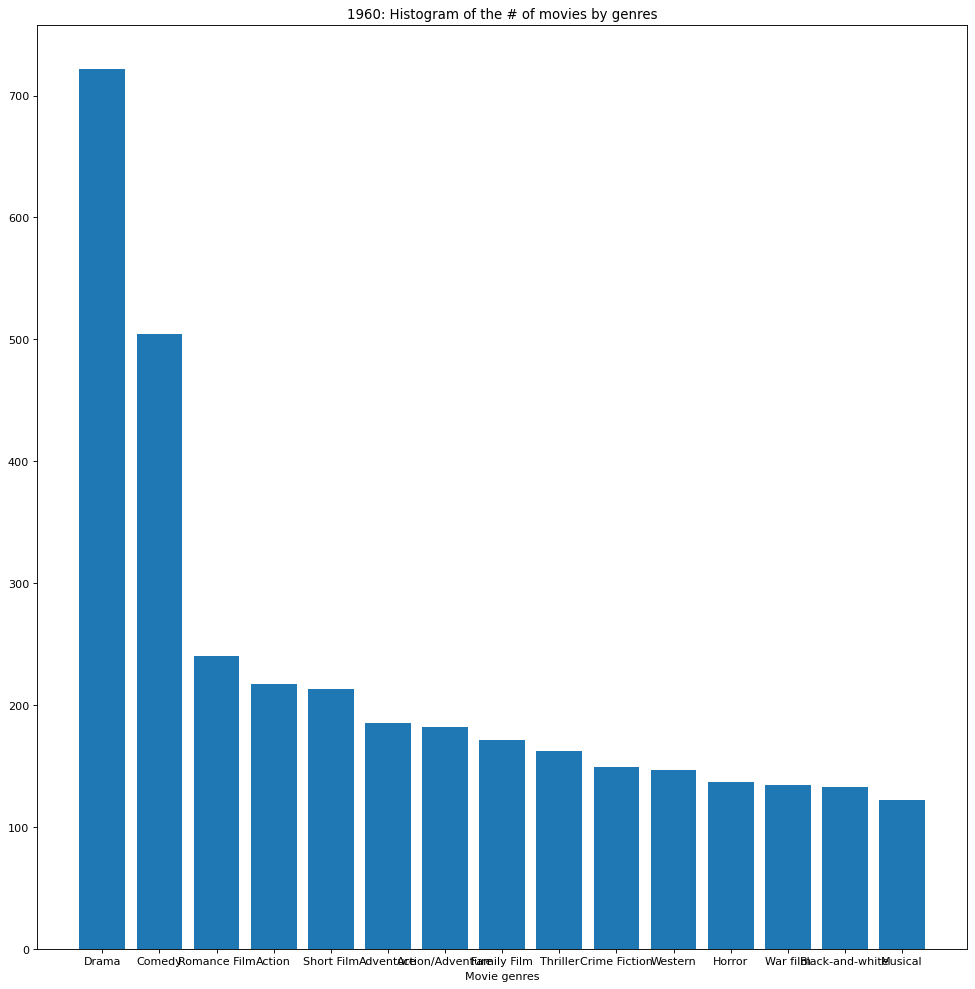

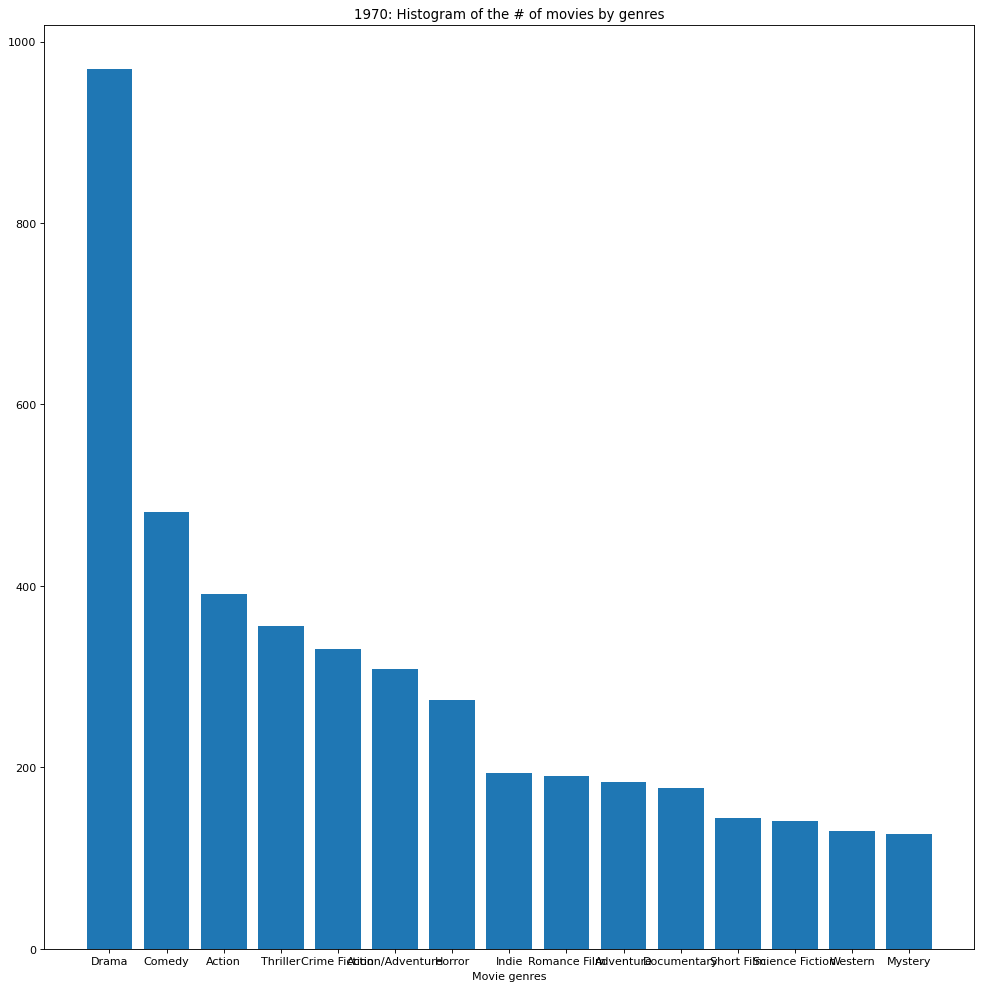

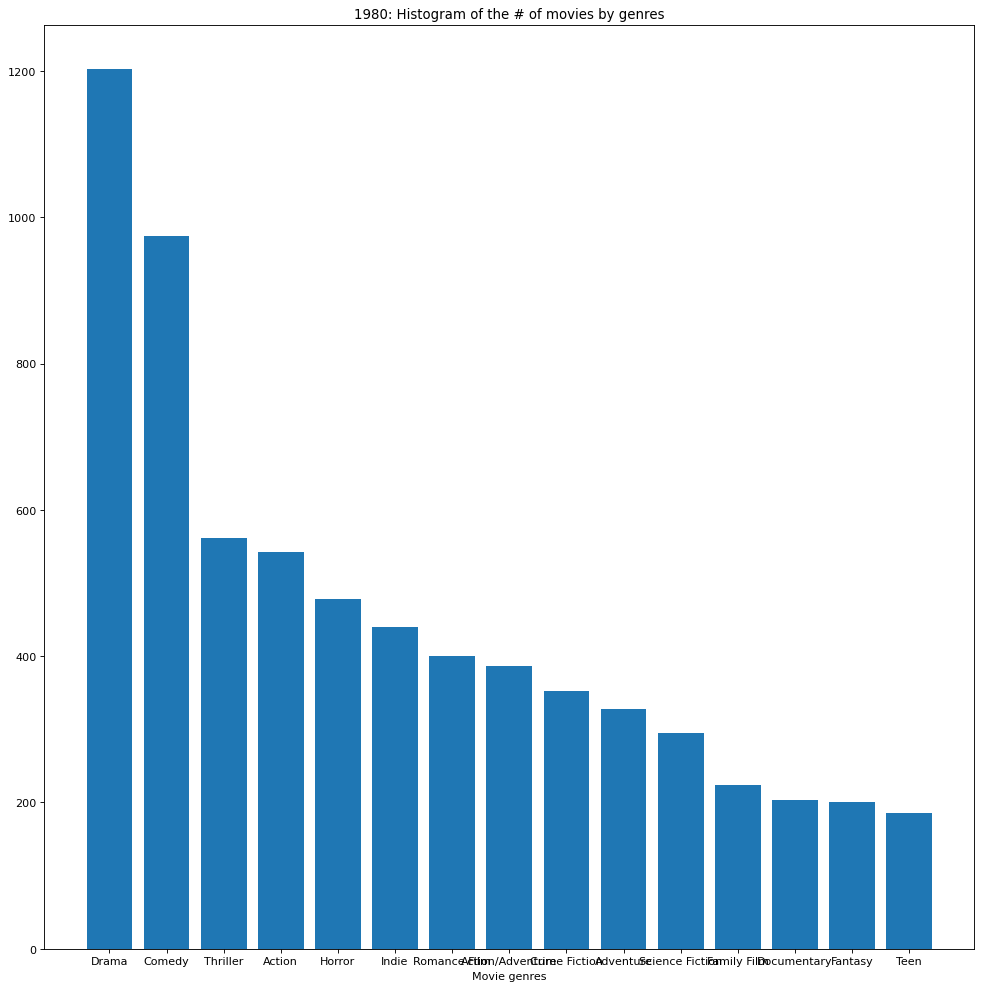

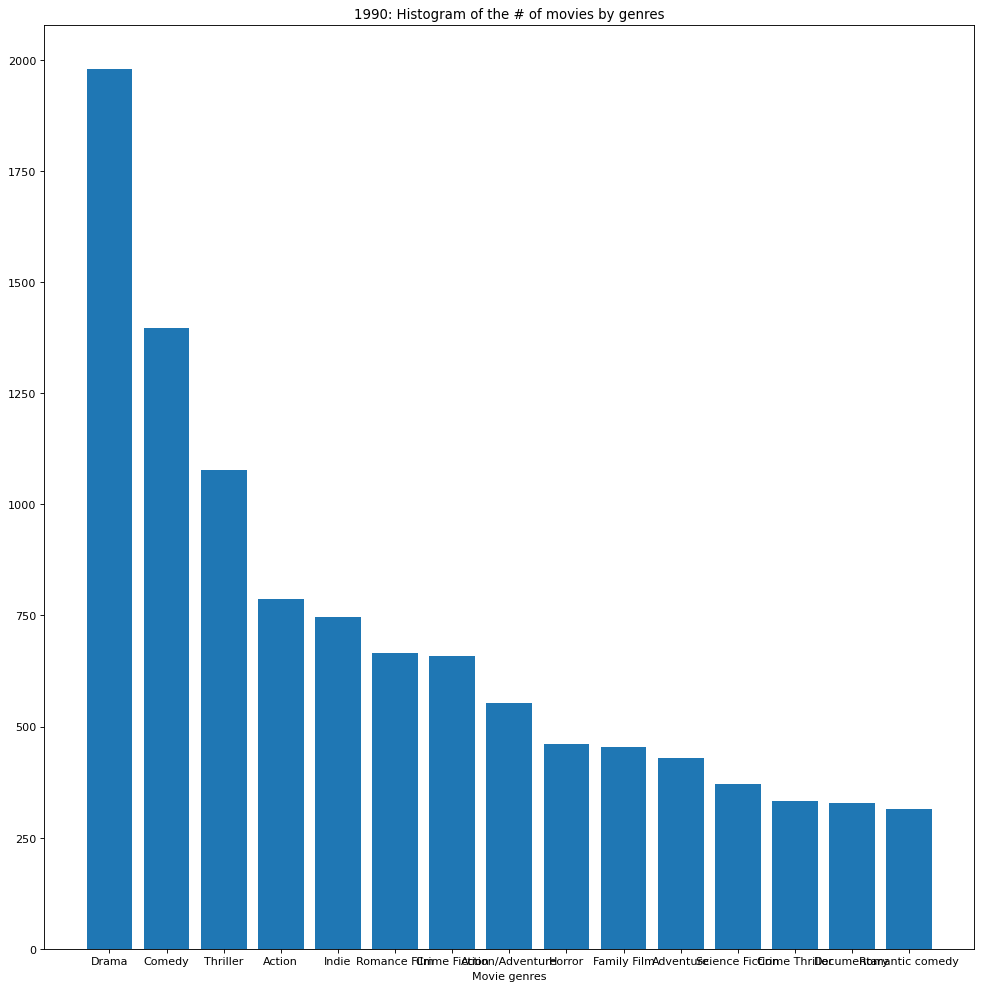

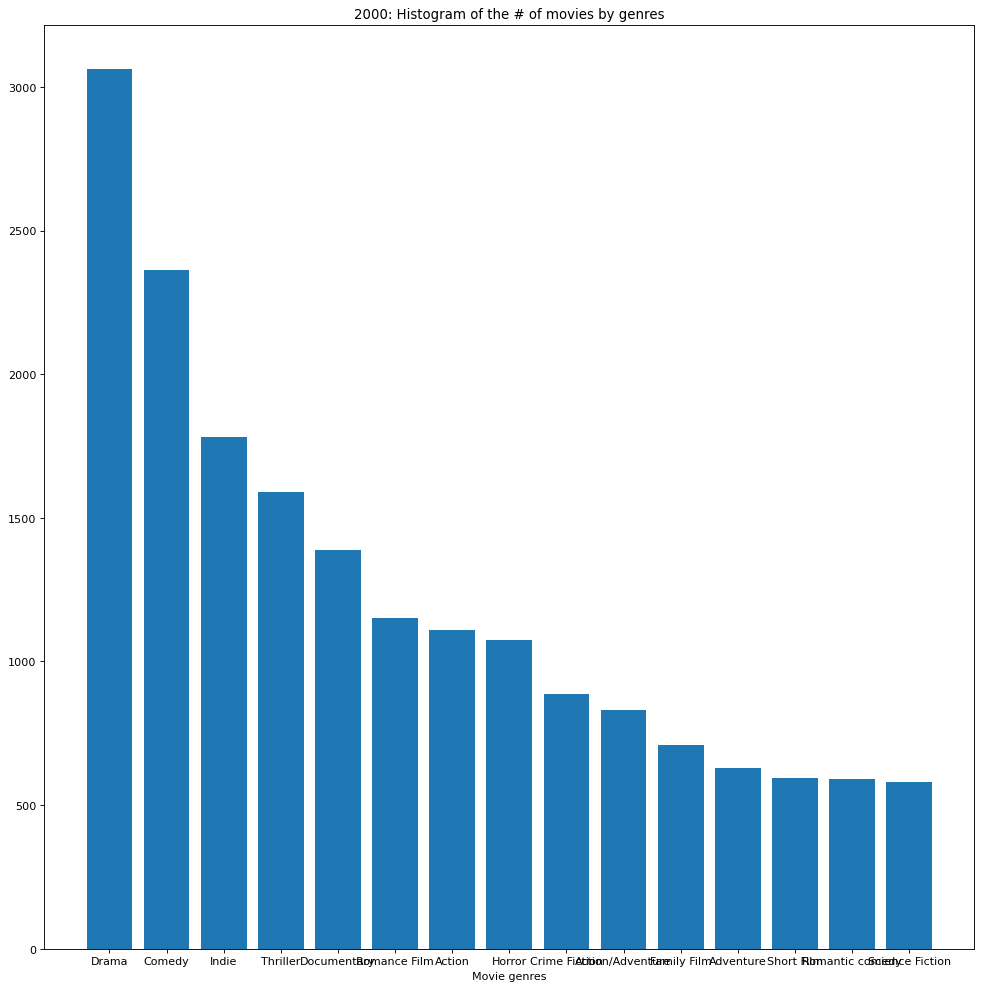

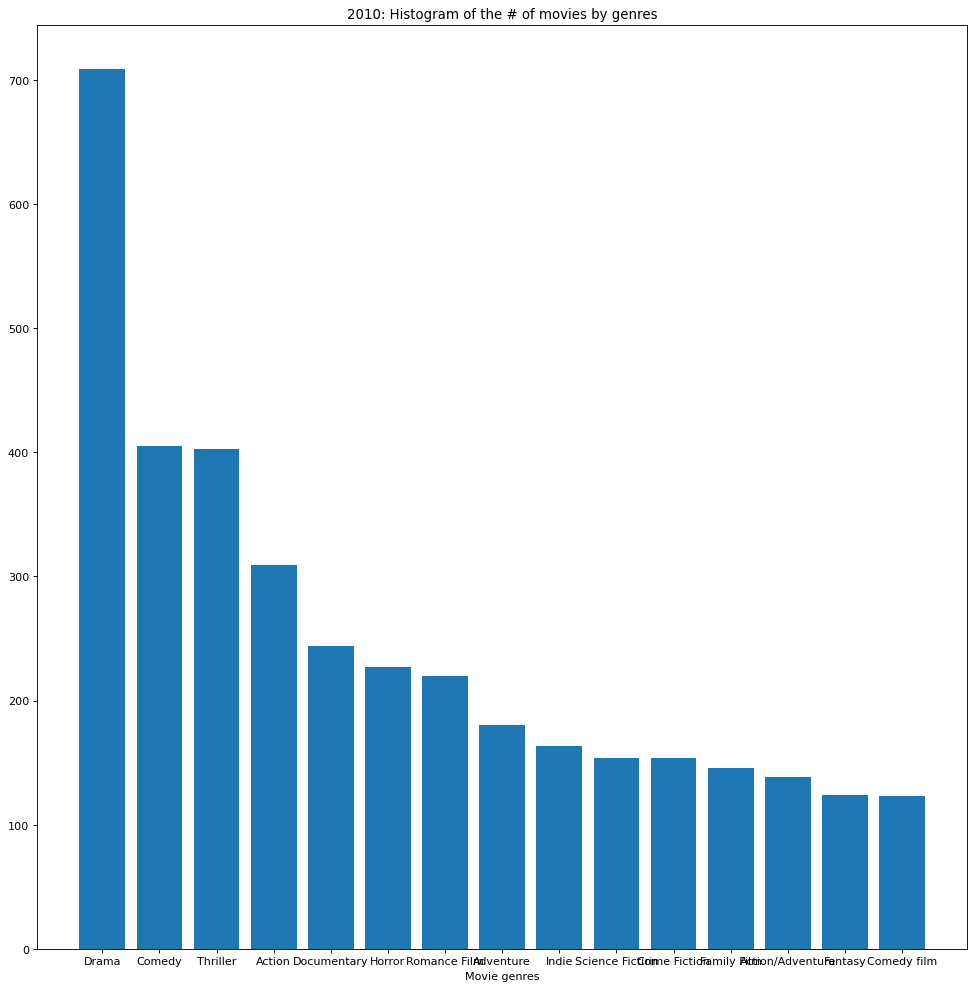

In [179]:
for decade in np.unique(usa_movie.release_date//10*10):
    plt.figure(figsize=(15, 15), dpi=80)
    
    if (genre_count.loc[decade].shape[0] >= 5):
        plt.bar(genre_count.loc[decade]['genre'].iloc[0:15], genre_count.loc[decade]['count'].iloc[0:15])
    else:
        plt.bar(genre_count.loc[decade]['genre'].values, genre_count.loc[decade]['count'])
    
    plt.xlabel('Movie genres'); plt.title(str(decade) + ': Histogram of the # of movies by genres')
    plt.show()

# Exploration of character metadata

Bar percentage men vs women

Plot number of character female vs male overtime.
Plot difference of number of character f v sm

See if difference in term of genre

Look at age of character m vs f

In [371]:
character_metadata = pd.read_csv(data_folder + "character.metadata.tsv", sep='\t', header=None)
character_metadata = character_metadata.iloc[:,[0,3,5]] #only keep what we are interested in
character_metadata.columns = ['movie_ID','name','gender','age']
character_metadata.name = character_metadata['name'].astype(str)
character_metadata = character_metadata.set_index('movie_ID')
character_metadata = character_metadata[character_metadata.gender.notna()]

df = usa_movie
#Filter out character that are not in the set of movie of interest (USA + released after ...)
movie_interest = list(set(np.unique(character_metadata.index)).intersection(df.index.values))
character_metadata = character_metadata.loc[movie_interest]

character_metadata.sample(10)

,name,gender
movie_ID,,
10210570,nan,F
35846887,nan,M
4010174,Major,M
535335,Manny,M
16023028,nan,M
1473196,Selene,F
23066976,nan,F
14090753,The District Attorney,M
156774,Kathryn Janeway,F


Almost half the charcter with a defined gender don't have a name. Look at each character portral

In [258]:
np.sum(character_metadata.name.notna())/len(character_metadata.name)

0.4578605638670814

In [268]:
character_metadata_nonan = character_metadata[character_metadata.name.notna()]
#Do still have enough data if look only at movies with at least defined character names?
mv_id, count = np.unique(character_metadata.loc[character_metadata_nonan.index,:].index, return_counts = True)
mv_id_nonan, count_nonan = np.unique(character_metadata_nonan.index, return_counts = True)
perc_defined_character = count_nonan/count

perc_defined_character.mean()

0.16469814158479587

In [372]:
f_character = character_metadata[character_metadata.gender == 'F']
m_character = character_metadata[character_metadata.gender == 'M']

len(f_character)/len(character_metadata)

0.32423245070980583

In [373]:
np.unique(m_character['name'])

array([' Prancer', "'3-5-0-0' Soloist", "'A' World Inmate #1", ...,
       'Óscar Romero', 'Über-Morlock', 'Калибан'], dtype=object)

In [292]:
f_nonan = f_character[f_character.name.notna()]
mv_id, count = np.unique(f_character.loc[f_nonan.index,:].index, return_counts = True)
mv_id_nonan, count_nonan = np.unique(f_nonan.index, return_counts = True)
perc_defined_character = count_nonan/count

np.sum(perc_defined_character>0.8)

1957

In [293]:
m_nonan = m_character[m_character.name.notna()]
mv_id, count = np.unique(m_character.loc[m_nonan.index,:].index, return_counts = True)
mv_id_nonan, count_nonan = np.unique(m_nonan.index, return_counts = True)
perc_defined_character = count_nonan/count

np.sum(perc_defined_character>0.8)

753

# Exploration of the summaries

In [100]:
summary_file = open(data_folder + 'plot_summaries.txt', 'r', encoding="utf8")
summaries = summary_file.readlines()

#Separate summary and movie ID
summaries = pd.DataFrame([summ.split("\t") for summ in summaries], columns=['movie_ID','summary'])
summaries['summary'] = summaries.summary.replace(r'\n',' ', regex=True) #Remove /n at end of summaries
summaries['movie_ID'] = summaries['movie_ID'].astype(float)
summaries = summaries.set_index('movie_ID')

In [101]:
#Count number of words in each summary
def count_words_simple(x):
    return len(x.split(" "))

summaries['length'] = summaries['summary'].apply(count_words_simple)

summaries.head()

,summary,length
movie_ID,,
23890098.0,"Shlykov, a hard-working taxi driver and Lyosha...",26
31186339.0,The nation of Panem consists of a wealthy Capi...,781
20663735.0,Poovalli Induchoodan is sentenced for six yea...,505
2231378.0,"The Lemon Drop Kid , a New York City swindler,...",854
595909.0,Seventh-day Adventist Church pastor Michael Ch...,398


In [102]:
summaries['length'].describe()

count    42306.000000
mean       313.286437
std        319.313137
min          5.000000
25%         89.000000
50%        189.000000
75%        457.000000
max       4943.000000
Name: length, dtype: float64

In [103]:
df = usa_movie
#Filter out summaries that are not in the set of movie of interest (USA + released after ...)
movie_interest = list(set(np.unique(summaries.index)).intersection(df.index.values))
summaries = summaries.loc[movie_interest]

summaries.head()

,summary,length
movie_ID,,
23199746.0,{{Plot}} The movie starts off in 1979 as a man...,906
6684682.0,Myles Falworth and his sister Meg live in ob...,184
3932174.0,The cartoon opens with two castaways adrift on...,397
14942228.0,This movie is a retelling of the Cinderella fa...,107
36306987.0,"A young Pakistani man, graduates from Princeto...",37


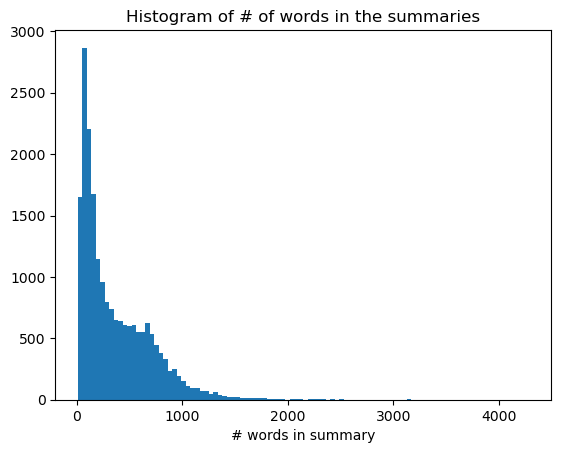

In [104]:
#Let's look at the distibution of the length of the summaries
plt.hist(summaries['length'],bins=100)
plt.xlabel('# words in summary'); plt.title('Histogram of # of words in the summaries')
plt.show()

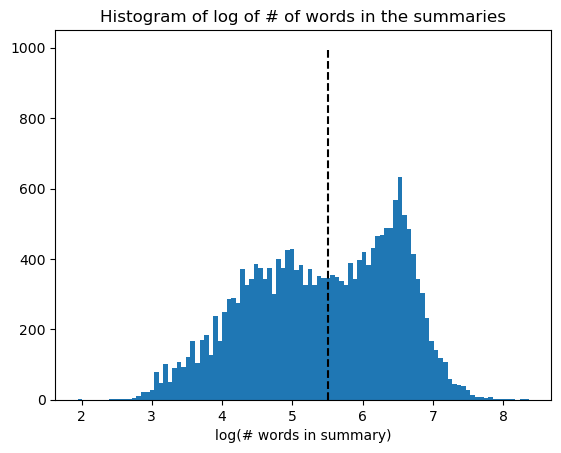

In [105]:
#The distribution is heavy tailed, apply log before binning
plt.hist(np.log(summaries['length']),bins=100)
plt.vlines(np.log(summaries['length']).median(), 0,1000, linestyles='dashed',color = 'black')
plt.xlabel('log(# words in summary)'); plt.title('Histogram of log of # of words in the summaries')
plt.show()

How many mention of character in average (f vs m) -> want many to get good average. Of course trade-off.

In [120]:
summaries_new = summaries[summaries.length >= 400]
print(summaries.shape);summaries_new.shape

(20240, 2)


(7430, 2)

## Parse words 

See mention f vs m

In [4]:
#pip install spacy
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [64]:
# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

# Process whole documents
text = 'Leila, the beauty.'
doc = nlp(text)
    
spacy.displacy.render(doc, style='dep')

In [66]:
text = 'Idiana Jons was attacked by the rebels, while she steals his airplane.'
doc = nlp(text)
    
spacy.displacy.render(doc, style='dep')

In [67]:
text = 'Mr. Krabs discovers a lot of people are visiting the beach, so he decides to go to sell them Krabby Patties. When SpongeBob, Squidward, and Mr. Krabs are on a surfboard, they meet up with Patrick and Sandy. Patrick tries to climb onto the board, but he causes it to tip, it collides into a large wave and sweeps the five friends up into separate places: SpongeBob, Patrick, and Squidward go to an island with young surfers, Mr. Krabs ends up stranded in the middle of the sea with his cash register, and Sandy is taken to a small island where she builds a helicopter from the supplies.SpongeBob, Patrick, and Squidward are told by the young surfers in the island that the only way to get back to Bikini Bottom is to surf there; unfortunately they do not know how to. Twitch, one of the surfers, tells them that there is one person who can teach them how to surf: Jack Kahuna Laguna (JKL). After they find JKL, he comes out of his hut and surfs on an enormous surfboard which astonishes the three. He later says that they have to ride a wave called "The Big One” in order to get back home, or else be trapped on the island forever. They practice surfing for some time, then get ready to ride "The Big One". Before they set off, JKL announces that The Big One demands a sacrifice.SpongeBob, Patrick, and Squidward ride the wave and they see Mr. Krabs. He jumps up onto the board and drops his cash register into the ocean, so JKL goes to retrieve it and acts as the sacrifice. SpongeBob, Patrick, Squidward, and Mr. Krabs are seen flying on the surfboard and approach Goo Lagoon. Sandys helicopter crash-lands in Goo Lagoon. A welcome home party has been thrown for the gang, and JKL returns with Krabs cash register. The episode ends with everyone dancing on the beach. '
doc = nlp(text)
    
spacy.displacy.render(doc, style='dep')

In [69]:
text = 'I sat Monica there. She was not sure what to do.'
doc = nlp(text)
    
spacy.displacy.render(doc, style='dep')

for token in doc:
    print (token.text, token.tag_, token.head.text, token.dep_)

I PRP sat nsubj
sat VBD sat ROOT
Monica NNP sat dobj
there RB sat advmod
. . sat punct
She PRP was nsubj
was VBD was ROOT
not RB was neg
sure JJ was acomp
what WP do dobj
to TO do aux
do VB sure xcomp
. . was punct


In [74]:
# Process whole documents
text = 'Leila looks beautiful.'
doc = nlp(text)
    
spacy.displacy.render(doc, style='dep')

In [336]:
# Process whole documents
text = 'Leila attacks the mean monkey'
doc = nlp(text)
    
spacy.displacy.render(doc, style='dep')

Get the gender of character in summary by using character metabase. Use gender-guesser python library for the rest.

In [375]:
import gender_guesser.detector as gender
d = gender.Detector()
print(d.get_gender("Andrea"))

female


In [ ]:
from allennlp.predictors.predictor import Predictor

model_url = "https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2020.02.27.tar.gz"
predictor = Predictor.from_path(model_url)

In [82]:
text = "Katniss is 25 years old today. It's her birthday. To celebrate, the 25yearsold plan to go out to a fancy restaurant with her friend, Tomas. He brings a straberry birthday cake. However, the birthday girl is alergic to straberries "

prediction = predictor.predict(document=text)  # get prediction
print("Clsuters:-")
for cluster in prediction['clusters']:
    print(cluster) 
print('\n\n')

print(text)
print("")
print('Coref resolved: ',predictor.coref_resolved(text))

Clsuters:-
[[0, 0], [9, 9], [15, 16], [26, 26], [40, 42]]
[[26, 29], [31, 31]]



Leila is 25 years old today. It's her birthday. To celebrate, the 25yearsold plan to go out to a fancy restaurant with her friend, Tomas. He brings a straberry birthday cake. However, the birthday girl is alergic to straberries 

Coref resolved:  Leila is 25 years old today. It's Leila's birthday. To celebrate, Leila plan to go out to a fancy restaurant with Leila's friend, Tomas. her friend, Tomas brings a straberry birthday cake. However, Leila is alergic to straberries 


In [1]:
text = "Leila is 25 years old today. It's her birthday. To celebrate, the 25yearsold plan to go out to a fancy restaurant with her friend, Tomas. He brings a straberry birthday cake. However, the birthday girl is alergic to straberries "

prediction = predictor.predict(document=text)  # get prediction
print("Clsuters:-")
for cluster in prediction['clusters']:
    print(cluster) 
print('\n\n')

print(text)
print("")
print('Coref resolved: ',predictor.coref_resolved(text))

NameError: name 'predictor' is not defined

In [78]:
def get_index_coreference(cluster):
    return np.hstack([np.arange(i[0], i[1]+1) for i in cluster])

cluster1 = prediction['clusters'][0]
index = get_index_coreference(cluster1)

np.array(prediction['document'])[index]

array(['Leila', 'her', 'the', '25yearsold', 'her', 'the', 'birthday',
       'girl'], dtype='<U11')

# Explore tv troope

See if we can get the model that they trained in the paper
-> see most common tropes f vs m

# Example processing of a summary

1. Run through NLP pipeline
2. Cluster reference to same person
3. Determine gender of these person
4. Look verb associated to their action, verb associated to passive 
5. Look at adjective asscocited to person
6. number mentions

In [84]:
pd.DataFrame(columns=['name','other_reference','number of mention','gender','action_verb','passive_verb','description'])

,name,other_reference,number of mention,gender,action_verb,passive_verb,description
